In [2]:
# Goal: Compare my 5577/6300 relation with the one from Maeda+2007
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import numba
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

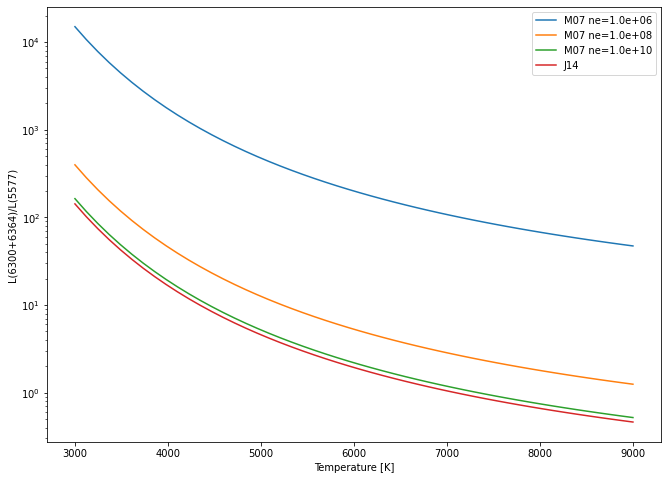

In [5]:
temp = np.linspace(3000, 9000)

plt.figure(figsize=(11,8))

for ne in [1e6, 1e8, 1e10]:
    t3 = temp/1e3
    # Maeda ratio (6300+6363)/5577
    maeda_ratio = 7.2 * (1+6.6e-9*ne*t3**0.02)/(1+1.6e-6*ne*t3**0.03)*np.exp(25.83/t3)
    
    plt.plot(temp, maeda_ratio, label='M07 ne=%.1e' % ne)
    
# Jerkstrand+2014 ratio 5577/(6300+6364)
j14_ratio = 38*np.exp(-25790/temp)
plt.plot(temp, 1/j14_ratio, label='J14')    
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('L(6300+6364)/L(5577)')
plt.legend();

In [6]:
# ok.. that looks reasonable - for high ne: M07 -> J14
# and probably better to have it as function of ne and a few cardinal temp points

In [3]:
# Code to estimate the d_2 factor in my equations

# estimate range of d_2
@numba.njit(inline='always')
def nu1_calc_lte(temp):
    g_u1 = 5
    g_g = 9
    E_1 = 22830 # K
    return g_u1/g_g * np.exp(-E_1/temp)

# simple estimate just solving eqn48 in J+Handbook to N_u
@numba.njit(inline='always')
def nu2_estimate0(temp, ne):
    Q_2g = 8.631e-6/temp**0.5 * 1 / 1 * ne
    Q_21 = 8.631e-6/temp**0.5 * 0.07 / 1 * ne
    E_u2 = 48620 # K
    E_u1 = 22830 # K
    A_21 = 1.26
    N_1 = nu1_calc_lte(temp)
    el1 = Q_2g*np.exp(-E_u2/temp)*1/9 + N_1*Q_21*np.exp(-(E_u2-E_u1)/temp)*1/5
    el2 = A_21 + Q_21 + Q_2g
    return el1/el2

@numba.njit(inline='always')
def nu2_calc_lte(temp):
    g_u2 = 1
    g_g = 9
    E_2 = 48620 # K
    return g_u2/g_g * np.exp(-E_2/temp)


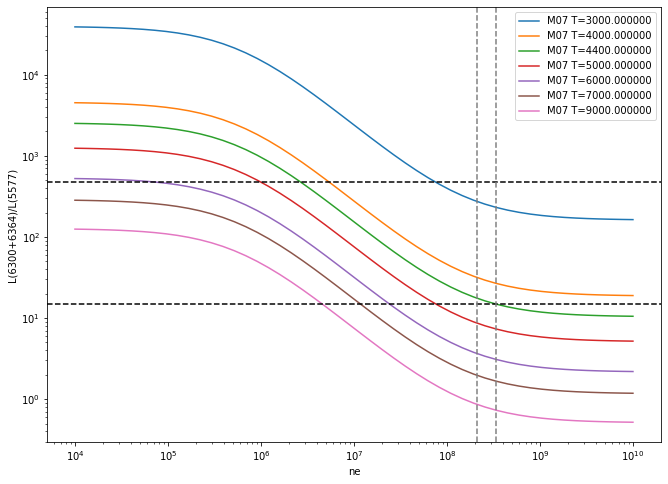

In [8]:
ne = np.logspace(4, 10, base=10)

plt.figure(figsize=(11,8))

for temp in [3000, 4000, 4400, 5000, 6000, 7000, 9000]:
    t3 = temp/1e3
    # Maeda ratio (6300+6363)/5577
    maeda_ratio = 7.2 * (1+6.6e-9*ne*t3**0.02)/(1+1.6e-6*ne*t3**0.03)*np.exp(25.83/t3)
    
    plt.plot(ne, maeda_ratio, label='M07 T=%f' % temp)
    
    # calculate d2 for combination
    d2 = nu2_estimate0(temp, ne)/nu2_calc_lte(temp)
    my_ratio = 38*d2*np.exp(-25790/temp)
    #plt.plot(ne, 1/my_ratio, label='S22 T=%f' % temp)
    
plt.ylabel('L(6300+6364)/L(5577)')
plt.xlabel('ne')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# keck_early estimate
plt.axhline(15, ls='--', color='black')

# keck_late lower limit
plt.axhline(480, ls='--', color='black')

# estimates from line volume
# upper limits on density
plt.axvline(3.4e8, ls='--', color='grey')
plt.axvline(2.1e8, ls='--', color='grey')

In [ ]:
# this gives us limits on temperature ranges!
# keck_early -> min T ~ 5000K
# keck_late -> min T ~ 3000K and max T ~ 6000K
# since T(keck_late) < T(keck_early) -> max T(keck_early) ~ 5000K

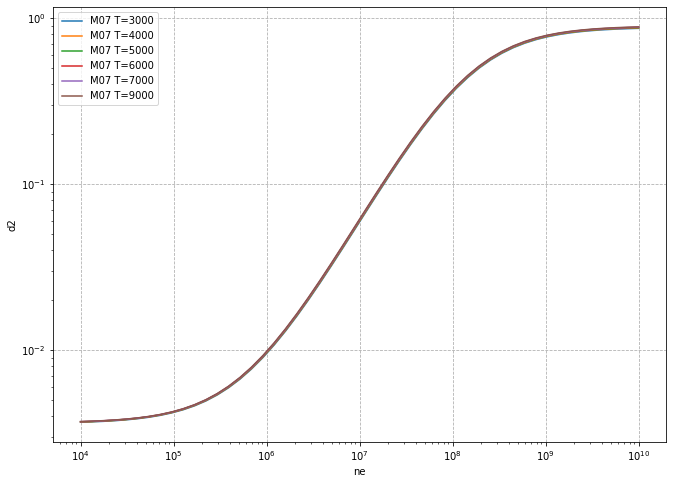

In [26]:
# Calculate d2(ne,T) from M07 ratio!

ne = np.logspace(4, 10, base=10)

plt.figure(figsize=(11,8))

for temp in [3000, 4000, 5000, 6000, 7000, 9000]:
    t3 = temp/1e3
    # Maeda ratio (6300+6363)/5577
    maeda_ratio = 7.2 * (1+6.6e-9*ne*t3**0.02)/(1+1.6e-6*ne*t3**0.03)*np.exp(25.83/t3)
    
    #plt.plot(ne, maeda_ratio, label='M07 T=%f' % temp)
    
    # calculate d2 for combination
    
    j14_ratio = 38*np.exp(-25790/temp)
    #plt.plot(ne, 1/my_ratio, label='S22 T=%f' % temp)
    d2 = (1/maeda_ratio)/j14_ratio
    plt.plot(ne, d2, label='M07 T=%.0f' % temp)
    
plt.ylabel('d2')
plt.xlabel('ne')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(ls='--')

In [ ]:
# Interesting! No dependence on the temperature!
# with ne~1e6 as min -> d2 min ~ 1e-2

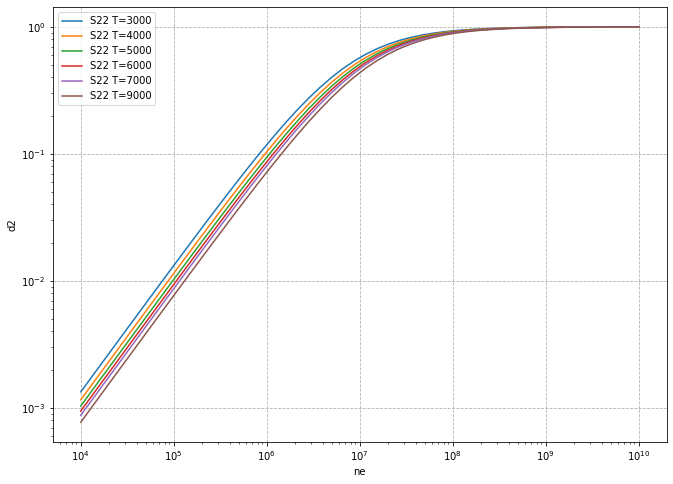

In [27]:
# Now lets see how my function behaves!

ne = np.logspace(4, 10, base=10)

plt.figure(figsize=(11,8))

for temp in [3000, 4000, 5000, 6000, 7000, 9000]:
    d2 = nu2_estimate0(temp, ne)/nu2_calc_lte(temp)
    plt.plot(ne, d2, label='S22 T=%.0f' % temp)
    
plt.ylabel('d2')
plt.xlabel('ne')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(ls='--')

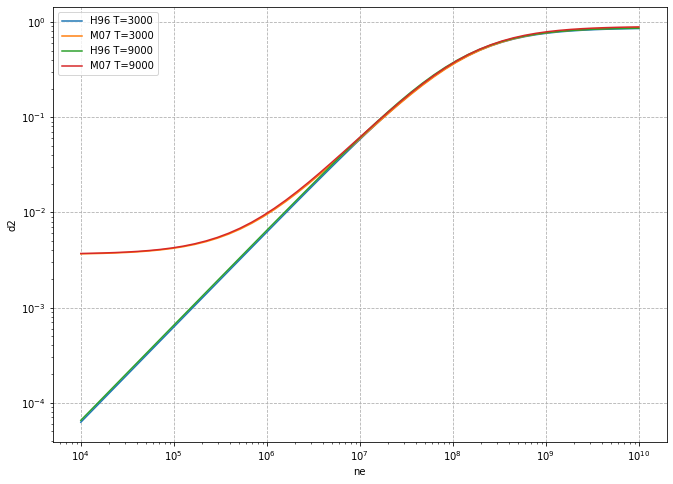

In [6]:
# Calculate d2(ne,T) from M07 ratio!

ne = np.logspace(4, 10, base=10)

plt.figure(figsize=(11,8))

for temp in [3000, 9000]:
    t3 = temp/1e3
    # Maeda ratio (6300+6363)/5577
    maeda_ratio = 7.2 * (1+6.6e-9*ne*t3**0.02)/(1+1.6e-6*ne*t3**0.03)*np.exp(25.83/t3)
    
    # Houck+1996 equation
    houck_ratio = 0.03*(1+1.44*t3**-0.034/(ne/1e8))*np.exp(25.83/t3)
    
    #plt.plot(ne, maeda_ratio, label='M07 T=%f' % temp)
    
    # calculate d2 for combination
    
    j14_ratio = 38*np.exp(-25790/temp)
    #plt.plot(ne, 1/my_ratio, label='S22 T=%f' % temp)
    d2 = (1/houck_ratio)/j14_ratio
    plt.plot(ne, d2, label='H96 T=%.0f' % temp)
    
    d2 = (1/maeda_ratio)/j14_ratio
    plt.plot(ne, d2, label='M07 T=%.0f' % temp)
    
plt.ylabel('d2')
plt.xlabel('ne')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(ls='--')

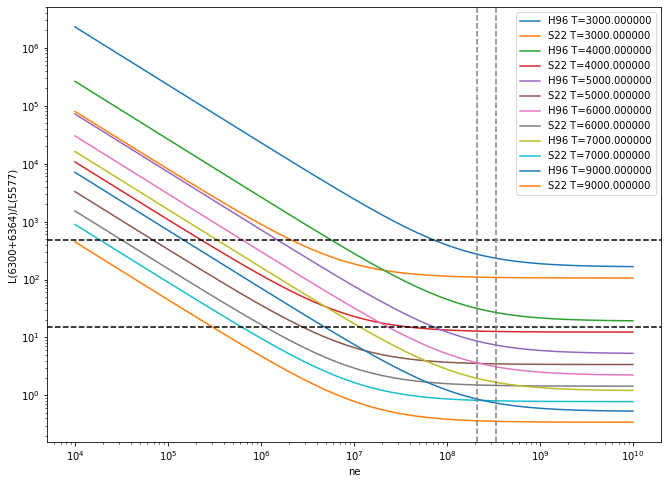

In [32]:
# ok.. lets look at the Houck+1996 paper (with Claes on it!)
# that one has L(6300)/L(5577)
ne = np.logspace(4, 10, base=10)

plt.figure(figsize=(11,8))

for temp in [3000, 4000, 5000, 6000, 7000, 9000]:
    t3 = temp/1e3
    # Houck+1996 equation
    houck_ratio = 0.03*(1+1.44*t3**-0.034/(ne/1e8))*np.exp(25.83/t3)
    
    plt.plot(ne, houck_ratio, label='H96 T=%f' % temp)
    
    # calculate d2 for combination
    d2 = nu2_estimate0(temp, ne)/nu2_calc_lte(temp)
    my_ratio = 51*d2*np.exp(-25790/temp)
    plt.plot(ne, 1/my_ratio, label='S22 T=%f' % temp)
    
plt.ylabel('L(6300+6364)/L(5577)')
plt.xlabel('ne')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.axhline(15, ls='--', color='black')
plt.axhline(480, ls='--', color='black')
plt.axvline(3.4e8, ls='--', color='grey')
plt.axvline(2.1e8, ls='--', color='grey')

In [ ]:
# ok.. also wrong compared to this (even though it doesn't show that saturating behavior..)